In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import talib
import pickle
from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings("ignore")

from ti import *

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing

from pmdarima import auto_arima

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from tensorflow.keras.optimizers import Adam

In [2]:
df = pd.read_csv("./data/stocks_ti.csv")

df["DATE"] = pd.to_datetime(df["DATE"])

df.set_index("DATE", inplace=True)

df

,SPY_3M IMPLIED VOL,SPY_HIGH,SPY_LOW,SPY_OPEN,SPY_SHORT INTEREST RATIO,SPY_ewm_log_ret_13d,SPY_ewm_log_ret_1d,SPY_ewm_log_ret_21d,SPY_ewm_log_ret_3d,SPY_ewm_log_ret_5d,...,XRT_macd_sig,XRT_rsi,XRT_rsi_13d_slope,XRT_rsi_1d_slope,XRT_rsi_21d_slope,XRT_rsi_3d_slope,XRT_rsi_5d_slope,XRT_rsi_8d_slope,tweet_sentiment,news_sentiment
DATE,,,,,,,,,,,,,,,,,,,,,
2015-01-02,14.0384,0.006498,-0.006639,0.004078,1.507,0.005375,-0.000535,0.006782,-0.010765,-0.000939,...,0.598815,67.988107,19.826342,-7.838144,5.204016,-1.944891,7.252436,10.295799,-0.131934,0.075776
2015-01-05,14.1676,-0.005173,-0.020061,-0.006152,1.507,0.006181,-0.018225,0.003427,-0.019749,-0.011550,...,0.593092,59.339623,16.598506,-8.648484,-0.103102,-8.596080,-3.993711,0.899108,-0.102601,0.116118
2015-01-06,14.3399,0.004945,-0.014305,0.001833,1.507,0.006670,-0.009464,-0.000383,-0.023986,-0.022225,...,0.567309,53.461876,14.660032,-5.877747,-4.602641,-22.364376,-16.471123,-4.402835,0.025503,0.050569
2015-01-07,14.4772,0.014409,0.005291,0.007975,1.507,0.006085,0.012384,-0.002870,-0.019645,-0.023421,...,0.548476,67.244094,17.009353,13.782219,11.666405,-0.744013,-0.691608,6.508423,-0.051485,0.125229
2015-01-08,14.5777,0.018851,0.008270,0.008368,1.507,0.004606,0.017589,-0.002922,0.000432,-0.015031,...,0.544027,64.685908,12.113201,-2.558186,7.219379,5.346286,-11.140343,1.352575,0.100507,0.138343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,12.9785,0.000934,-0.000997,0.000778,2.463,0.021663,0.000031,0.028050,0.003051,0.008625,...,0.359009,67.779961,23.646861,-0.862487,24.291589,8.342875,14.908339,-0.857149,-0.048913,0.238482
2019-12-26,12.9736,0.005340,0.001276,0.001307,2.463,0.022183,0.005309,0.028235,0.004959,0.009226,...,0.380095,71.863118,22.659296,4.083157,26.104189,8.547421,17.008749,15.327685,0.195297,0.277311
2019-12-27,12.9749,0.002659,-0.002046,0.002474,2.463,0.023044,-0.000248,0.028175,0.005026,0.008180,...,0.403777,66.666667,15.808632,-5.196451,15.789474,-1.975781,7.229581,16.047198,0.027661,0.249240


In [3]:
df['SPY_HIGH']

DATE
2015-01-02    0.006498
2015-01-05   -0.005173
2015-01-06    0.004945
2015-01-07    0.014409
2015-01-08    0.018851
                ...   
2019-12-24    0.000934
2019-12-26    0.005340
2019-12-27    0.002659
2019-12-30    0.000743
2019-12-31    0.003265
Name: SPY_HIGH, Length: 1250, dtype: float64

In [11]:
df['SPY_HIGH'].rolling(window = 3).sum().shift(-3)

DATE
2015-01-02    0.014181
2015-01-05    0.038205
2015-01-06    0.035782
2015-01-07    0.023086
2015-01-08    0.018103
                ...   
2019-12-24    0.008743
2019-12-26    0.006667
2019-12-27         NaN
2019-12-30         NaN
2019-12-31         NaN
Name: SPY_HIGH, Length: 1250, dtype: float64

In [3]:
df.columns[:30]

Index(['SPY_3M IMPLIED VOL', 'SPY_HIGH', 'SPY_LOW', 'SPY_OPEN',
       'SPY_SHORT INTEREST RATIO', 'SPY_ewm_log_ret_13d', 'SPY_ewm_log_ret_1d',
       'SPY_ewm_log_ret_21d', 'SPY_ewm_log_ret_3d', 'SPY_ewm_log_ret_5d',
       'SPY_ewm_log_ret_8d', 'SPY_ivol_13d_slope', 'SPY_ivol_1d_slope',
       'SPY_ivol_21d_slope', 'SPY_ivol_3d_slope', 'SPY_ivol_5d_slope',
       'SPY_ivol_8d_slope', 'SPY_log_ret_13d', 'SPY_log_ret_1d',
       'SPY_log_ret_21d', 'SPY_log_ret_3d', 'SPY_log_ret_5d', 'SPY_log_ret_8d',
       'SPY_macd', 'SPY_macd_13d_slope', 'SPY_macd_1d_slope',
       'SPY_macd_21d_slope', 'SPY_macd_3d_slope', 'SPY_macd_5d_slope',
       'SPY_macd_8d_slope'],
      dtype='object')

<Axes: xlabel='DATE'>

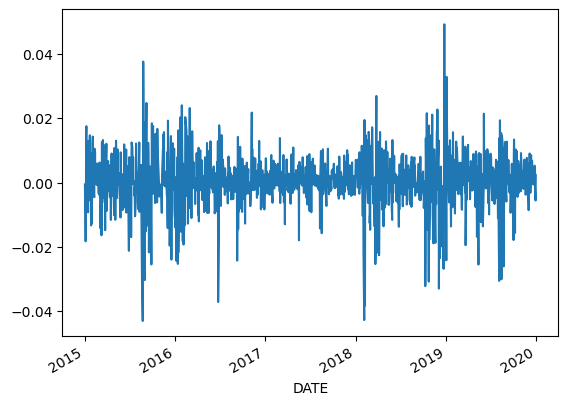

In [4]:
df["SPY_log_ret_1d"].plot()

# Functions

In [18]:
def prepare_X_y(X, y, test_size=0.2):
    # Calculate split index
    split_idx = int(len(X) * (1 - test_size))

    # Split into training and testing sets based on the calculated index
    X_train = X.iloc[:split_idx]
    X_test = X.iloc[split_idx:]
    y_train = y.iloc[:split_idx]
    y_test = y.iloc[split_idx:]

    # Standardization
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert scaled arrays back to DataFrames for easier handling in later processes
    X_train_scaled = pd.DataFrame(
        X_train_scaled, columns=X_train.columns, index=X_train.index
    )
    X_test_scaled = pd.DataFrame(
        X_test_scaled, columns=X_test.columns, index=X_test.index
    )

    return (X_train_scaled, X_test_scaled, y_train, y_test)

In [158]:
# Function 3: Test MSE and R2
def test_mse_r2(model, X_test, y_test):
    """
    Calculates and prints the MSE and R^2 for the test set.

    Parameters:
    - model: The trained model to evaluate
    - X_test: Testing features
    - y_test: Testing target variable
    """
    predictions = model.predict(X_test)
    plt.plot(y_test.index, y_test, label="Actual")
    plt.plot(y_test.index, predictions, label="Predict")
    plt.legend()
    plt.show()
    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    print(f"MSE: {mse}, R^2: {r2}")

In [20]:
# Function 1: Train and Fit a Random Forest Model
def train_random_forest(X_train, y_train, n_estimators=100, max_depth=None):
    model = RandomForestRegressor(
        n_estimators=n_estimators, max_depth=max_depth, random_state=42
    )
    model.fit(X_train, y_train)
    return model


# Function 2: Run Grid Search with Cross Validation
def run_grid_search(model, param_grid, X_train, y_train, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    gscv = GridSearchCV(
        estimator=model, param_grid=param_grid, cv=tscv, verbose=2, n_jobs=-1
    )
    gscv.fit(X_train, y_train)
    return gscv

# Set 1: only price and vol data ~ 3day log return

In [21]:
df.columns[10:25]

Index(['SPY_ewm_log_ret_8d', 'SPY_ivol_13d_slope', 'SPY_ivol_1d_slope',
       'SPY_ivol_21d_slope', 'SPY_ivol_3d_slope', 'SPY_ivol_5d_slope',
       'SPY_ivol_8d_slope', 'SPY_log_ret_13d', 'SPY_log_ret_1d',
       'SPY_log_ret_21d', 'SPY_log_ret_3d', 'SPY_log_ret_5d', 'SPY_log_ret_8d',
       'SPY_macd', 'SPY_macd_13d_slope'],
      dtype='object')

In [163]:
y = df["SPY_log_ret_1d"][1:]
y = df["SPY_log_ret_1d"].rolling(13).sum()[13:]

X1 = df[
    [
        "SPY_3M IMPLIED VOL",
        "SPY_SHORT INTEREST RATIO",
        "SPY_ivol_13d_slope",
        "SPY_ivol_1d_slope",
        "SPY_ivol_21d_slope",
        "SPY_ivol_3d_slope",
        "SPY_ivol_5d_slope",
        "SPY_ivol_8d_slope",
        "SPY_log_ret_13d",
        "SPY_log_ret_1d",
        "SPY_log_ret_21d",
        "SPY_log_ret_3d",
        "SPY_log_ret_5d",
        "SPY_log_ret_8d",
    ]
][12:-1]

(X_train1, X_test1, y_train1, y_test1) = prepare_X_y(X1, y, test_size=0.2)

<Axes: >

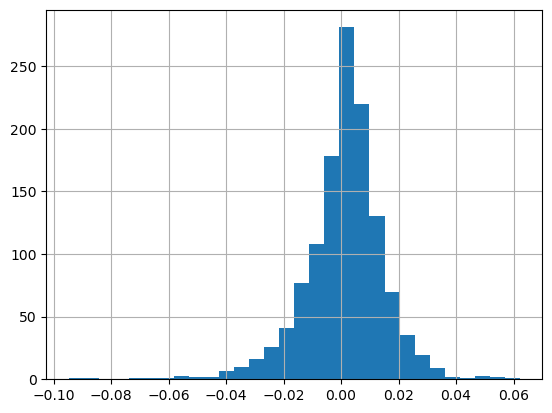

In [164]:
df["SPY_log_ret_1d"].rolling(3).sum().hist(bins=30)

## Linear regression

In [173]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Fit the model with the training data
lr_model.fit(X_train1, y_train1)

# Coefficients and intercept
coefficients = lr_model.coef_
intercept = lr_model.intercept_

# Predict on the training data
y_train_pred = lr_model.predict(X_train1)

# Calculate metrics on training data
train_mse = mean_squared_error(y_train1, y_train_pred)
train_r2 = r2_score(y_train1, y_train_pred)

# Predict on the testing data
y_test_pred = lr_model.predict(X_test1)

# Calculate metrics on testing data
test_mse = mean_squared_error(y_test1, y_test_pred)
test_r2 = r2_score(y_test1, y_test_pred)

{
    "coefficients": coefficients,
    "intercept": intercept,
    "training_metrics": {"MSE": train_mse, "R2": train_r2},
    "testing_metrics": {"MSE": test_mse, "R2": test_r2},
}

{'coefficients': array([ 7.99495521e-04, -1.32334028e-05,  1.54928576e-02, -1.10922682e-03,
        -6.45959884e-03,  2.46900655e-03,  4.52390339e-03, -1.54347608e-02,
         2.05386309e-02,  2.82268976e-06,  1.51602573e-03, -2.15433692e-04,
         1.50928841e-03,  2.48782299e-03]),
 'intercept': 0.0027618492327149656,
 'training_metrics': {'MSE': 0.00013879475971236864, 'R2': 0.8150036556846627},
 'testing_metrics': {'MSE': 0.00011229160507771784, 'R2': 0.821261693570869}}

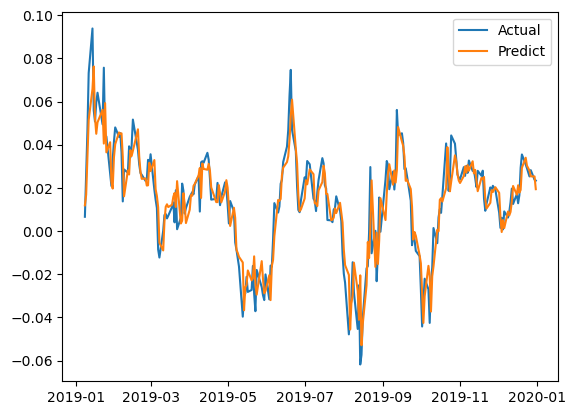

MSE: 0.00011229160507771784, R^2: 0.821261693570869


In [174]:
test_mse_r2(lr_model, X_test1, y_test1)

## Random Forest

In [136]:
model_rf1 = train_random_forest(X_train1, y_train1, n_estimators=100, max_depth=None)

# Perform Grid Search with Time Series Cross-Validation
param_grid = {
    "n_estimators": [50, 100, 200, 400],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
}

In [138]:
# best_model_rf1 = run_grid_search(model_rf1, param_grid, X_train1, y_train1, n_splits=3)

# # Display the best parameters and score
# print(f"Best Parameters: {best_model_rf1.best_params_}")
# print(f"Best Score: {best_model_rf1.best_score_}")

In [139]:
# test_mse_r2(best_model_rf1, X_train1, y_train1)

# # Test MSE and R2 with the best model found
# test_mse_r2(best_model_rf1, X_test1, y_test1)

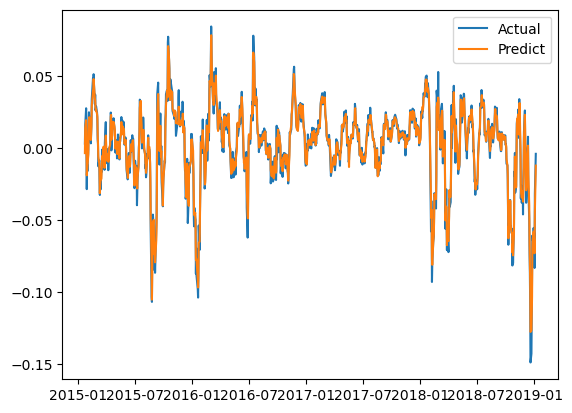

MSE: 2.1395725219736773e-05, R^2: 0.9714821297444557


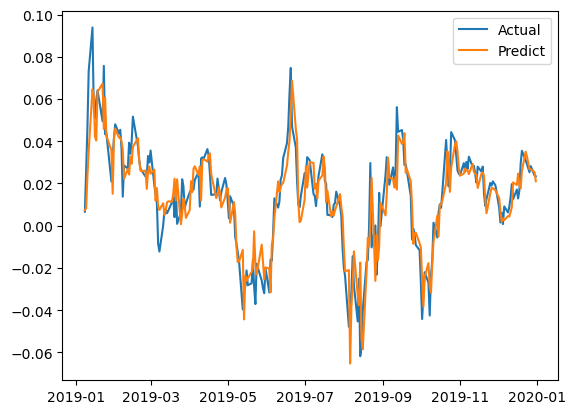

MSE: 0.00013656906451619175, R^2: 0.7826184487670257


In [140]:
# simple model
model_rf1.fit(X_train1, y_train1)

test_mse_r2(model_rf1, X_train1, y_train1)
test_mse_r2(model_rf1, X_test1, y_test1)

# Set 2: spy + ti (spy)

In [32]:
df.columns[23:38]

Index(['SPY_macd', 'SPY_macd_13d_slope', 'SPY_macd_1d_slope',
       'SPY_macd_21d_slope', 'SPY_macd_3d_slope', 'SPY_macd_5d_slope',
       'SPY_macd_8d_slope', 'SPY_macd_sig', 'SPY_rsi', 'SPY_rsi_13d_slope',
       'SPY_rsi_1d_slope', 'SPY_rsi_21d_slope', 'SPY_rsi_3d_slope',
       'SPY_rsi_5d_slope', 'SPY_rsi_8d_slope'],
      dtype='object')

In [178]:
# y = df["SPY_log_ret_1d"][1:]

# X2 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 23:38]], axis=1)[:-1]

# 3 days return
y = df["SPY_log_ret_1d"].rolling(13).sum()[13:]
X2 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 23:38]], axis=1)[12:-1]

(X_train2, X_test2, y_train2, y_test2) = prepare_X_y(X2, y, test_size=0.2)

## Linear regression

In [179]:
# Initialize the Linear Regression model
lr_model2 = LinearRegression()

# Fit the model with the training data
lr_model2.fit(X_train2, y_train2)

# Coefficients and intercept
coefficients2 = lr_model2.coef_
intercept2 = lr_model2.intercept_

# Predict on the training data
y_train_pred2 = lr_model2.predict(X_train2)

# Calculate metrics on training data
train_mse2 = mean_squared_error(y_train2, y_train_pred2)
train_r22 = r2_score(y_train2, y_train_pred2)

# Predict on the testing data
y_test_pred2 = lr_model2.predict(X_test2)

# Calculate metrics on testing data
test_mse2 = mean_squared_error(y_test2, y_test_pred2)
test_r22 = r2_score(y_test2, y_test_pred2)

{
    "coefficients": coefficients2,
    "intercept": intercept2,
    "training_metrics": {"MSE": train_mse2, "R2": train_r22},
    "testing_metrics": {"MSE": test_mse2, "R2": test_r22},
}

{'coefficients': array([ 5.83377728e-04, -2.44625635e-03, -1.50806091e-03,  2.04487595e-03,
        -5.59946446e-05, -2.28617076e-02,  8.23438769e-03,  1.48962139e-02,
         9.86214536e-03, -1.54693145e-02,  3.75241931e-02,  4.49185681e-01,
        -8.79790440e-03, -1.91186887e-02, -1.35611660e-02, -3.84815038e-02,
        -1.44596505e-02, -6.55437847e-02, -4.08935065e-01, -1.37694620e-03,
         4.65032745e-03,  7.78161975e-04, -1.34311598e-03,  1.61595716e-03,
         2.61081142e-03, -4.49257756e-03]),
 'intercept': 0.002761849232714959,
 'training_metrics': {'MSE': 0.00012512233798233033, 'R2': 0.8332273122783004},
 'testing_metrics': {'MSE': 0.0001020246610922811, 'R2': 0.8376039319678501}}

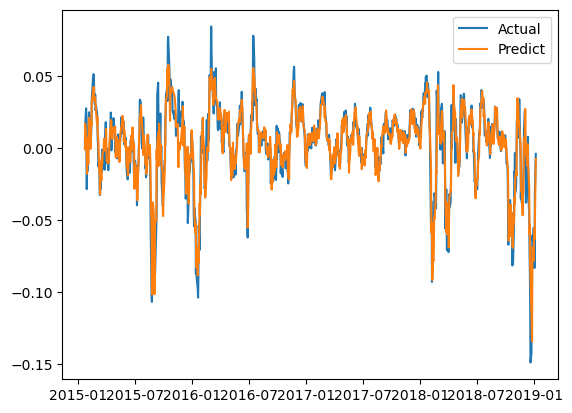

MSE: 0.00012512233798233033, R^2: 0.8332273122783004


In [180]:
test_mse_r2(lr_model2, X_train2, y_train2)

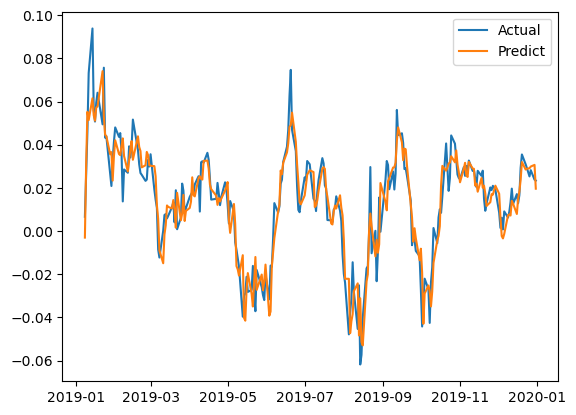

MSE: 0.0001020246610922811, R^2: 0.8376039319678501


In [181]:
test_mse_r2(lr_model2, X_test2, y_test2)

## Random Forest

In [182]:
model_rf2 = train_random_forest(X_train2, y_train2, n_estimators=100, max_depth=None)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}
Best Score: 0.3925228706185517


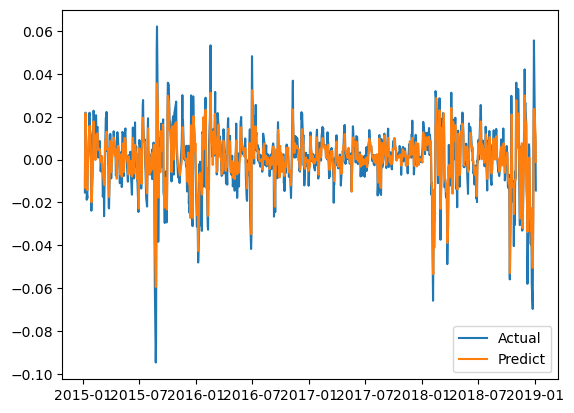

MSE: 4.0614773765581076e-05, R^2: 0.8107092670173444


In [128]:
best_model_rf2 = run_grid_search(model_rf2, param_grid, X_train2, y_train2, n_splits=3)

# Display the best parameters and score
print(f"Best Parameters: {best_model_rf2.best_params_}")
print(f"Best Score: {best_model_rf2.best_score_}")

test_mse_r2(best_model_rf2, X_train2, y_train2)

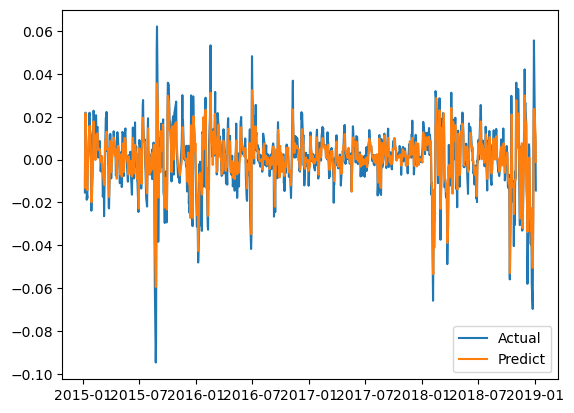

MSE: 4.0614773765581076e-05, R^2: 0.8107092670173444


In [176]:
test_mse_r2(best_model_rf2, X_train2, y_train2)

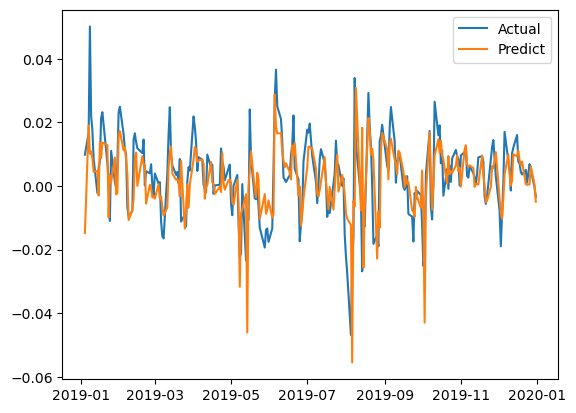

MSE: 9.900585679169305e-05, R^2: 0.3647375754251544


In [177]:
test_mse_r2(best_model_rf2, X_test2, y_test2)

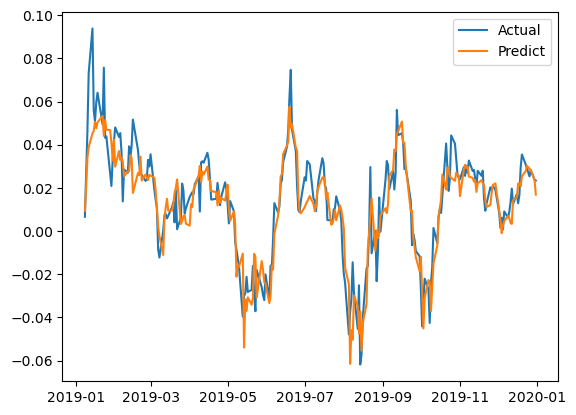

MSE: 0.00013050841297381743, R^2: 0.7922653906892767


In [183]:
# simple model
model_rf2.fit(X_train2, y_train2)

test_mse_r2(model_rf2, X_test2, y_test2)

# Set 3: spy + sector + ti (spy & sectors)

In [165]:
# y = df["SPY_log_ret_1d"][1:]
# X3 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 23:-2]], axis=1)[:-1].ffill()


y = df["SPY_log_ret_1d"].rolling(13).sum()[13:]
X3 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 23:-2]], axis=1)[12:-1].ffill()

(X_train3, X_test3, y_train3, y_test3) = prepare_X_y(X3, y, test_size=0.2)

## Linear regression

In [184]:
# Initialize the Linear Regression model
lr_model3 = LinearRegression()

# Fit the model with the training data
lr_model3.fit(X_train3, y_train3)

# Coefficients and intercept
coefficients3 = lr_model3.coef_
intercept3 = lr_model3.intercept_

# Predict on the training data
y_train_pred3 = lr_model3.predict(X_train3)

# Calculate metrics on training data
train_mse3 = mean_squared_error(y_train3, y_train_pred3)
train_r23 = r2_score(y_train3, y_train_pred3)

# Predict on the testing data
y_test_pred3 = lr_model3.predict(X_test3)

# Calculate metrics on testing data
test_mse3 = mean_squared_error(y_test3, y_test_pred3)
test_r23 = r2_score(y_test3, y_test_pred3)

{
    "coefficients": coefficients3,
    "intercept": intercept3,
    "training_metrics": {"MSE": train_mse3, "R2": train_r23},
    "testing_metrics": {"MSE": test_mse3, "R2": test_r23},
}

{'coefficients': array([-6.36573769e-02, -4.86752810e-03, -2.57045201e-03,  1.87660848e-03,
         4.13648575e-03,  2.98498969e-01,  2.99328487e-02,  1.05471469e-01,
         4.53164066e-02,  1.19880181e-01, -1.96647299e-01,  1.20095610e+00,
        -2.28258451e-01, -1.15099454e-01,  3.79409055e-03, -1.43456779e-01,
        -2.19151326e-01,  1.68715412e-01, -1.46754915e+00, -1.80685316e-03,
         3.82890766e-03, -1.53798289e-03,  2.45564276e-03,  2.65752457e-03,
         4.37768904e-03,  2.07185557e-03, -1.57405263e-02, -1.37330232e-03,
         1.63852656e-05,  4.85670089e-05, -3.02573367e-03, -6.91962165e-03,
        -3.83072173e-04, -1.05216470e-02, -1.47415509e-02,  2.21305919e-03,
         1.28663019e-02, -7.83851826e-03, -9.36892892e-05,  1.31688345e-02,
         2.98590070e-03, -1.11319134e-02,  1.22318954e-02,  5.25586671e-03,
        -3.83072173e-04,  4.49746147e-03,  4.90104825e-04, -1.62096863e-03,
         5.36308362e-03,  9.82807118e-02, -1.14454443e-02, -1.05401608e-

# Random Forest

In [185]:
model_rf3 = train_random_forest(X_train3, y_train3, n_estimators=100, max_depth=None)

In [186]:
# best_model_rf3 = run_grid_search(model_rf3, param_grid, X_train3, y_train3, n_splits=3)

# # Display the best parameters and score
# print(f"Best Parameters: {best_model_rf3.best_params_}")
# print(f"Best Score: {best_model_rf3.best_score_}")

# test_mse_r2(best_model_rf3, X_train3, y_train3)

In [187]:
# test_mse_r2(best_model_rf3, X_test3, y_test3)

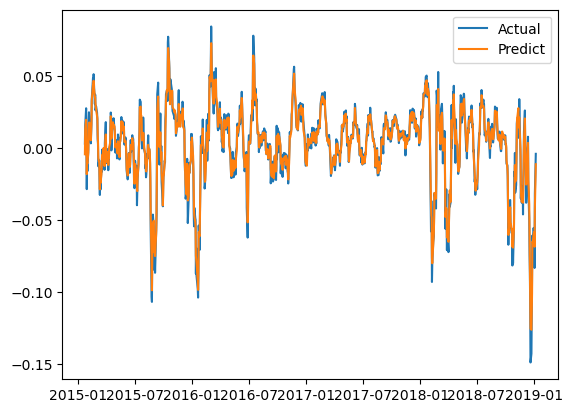

MSE: 1.9237551793286206e-05, R^2: 0.9743587094879508


In [188]:
test_mse_r2(model_rf3, X_train3, y_train3)

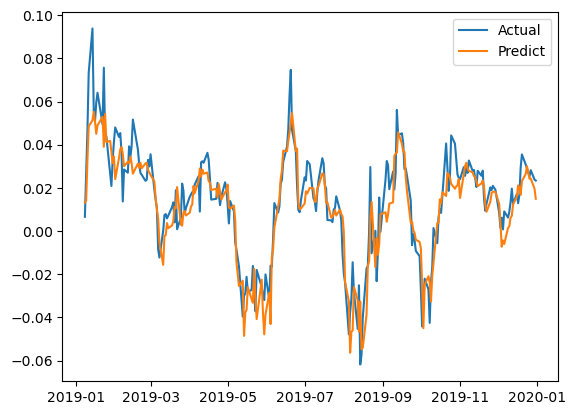

MSE: 0.00012908220515423494, R^2: 0.7945355334137637


In [189]:
test_mse_r2(model_rf3, X_test3, y_test3)

# Set 4: All (including Tweet Sentiment and News Sentiment)

In [153]:
y = df["SPY_log_ret_1d"].rolling(13).sum()[13:]

X4 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 23:]], axis=1)[12:-1].ffill()

(X_train4, X_test4, y_train4, y_test4) = prepare_X_y(
    X4, y, test_size=0.2
)

## Linear regression

In [143]:
# Initialize the Linear Regression model
lr_model4 = LinearRegression()

# Fit the model with the training data
lr_model4.fit(X_train4, y_train4)

# Coefficients and intercept
coefficients4 = lr_model4.coef_
intercept4 = lr_model4.intercept_

# Predict on the training data
y_train_pred4 = lr_model4.predict(X_train4)

# Calculate metrics on training data
train_mse4 = mean_squared_error(y_train4, y_train_pred4)
train_r24 = r2_score(y_train4, y_train_pred4)

# Predict on the testing data
y_test_pred4 = lr_model4.predict(X_test4)

# Calculate metrics on testing data
test_mse4 = mean_squared_error(y_test4, y_test_pred4)
test_r24 = r2_score(y_test4, y_test_pred4)

{
    "coefficients": coefficients4,
    "intercept": intercept4,
    "training_metrics": {"MSE": train_mse4, "R2": train_r24},
    "testing_metrics": {"MSE": test_mse4, "R2": test_r24},
}

{'coefficients': array([-6.38077032e-02, -4.70936792e-03, -2.81087465e-03,  1.91062751e-03,
         4.11870061e-03,  2.96521836e-01,  3.03502847e-02,  1.07614032e-01,
         4.69305128e-02,  1.18820866e-01, -1.98283893e-01,  1.21418678e+00,
        -2.27056405e-01, -1.16111656e-01,  3.21676722e-03, -1.46270812e-01,
        -2.18333220e-01,  1.68524712e-01, -1.47982974e+00, -2.24895593e-03,
         3.74943689e-03, -1.40068396e-03,  2.72984168e-03,  2.56007571e-03,
         4.61501680e-03,  1.89625810e-03, -1.52390810e-02, -1.38092931e-03,
        -4.73845484e-05,  3.04212948e-05, -2.91659593e-03, -5.93214278e-03,
        -2.89956630e-04, -1.11486249e-02, -1.49182303e-02,  2.63826826e-03,
         1.24511110e-02, -7.27393777e-03, -2.94405851e-04,  1.29132175e-02,
         3.17681723e-03, -1.13542543e-02,  1.23213979e-02,  5.20475019e-03,
        -2.89956630e-04,  4.16268929e-03,  5.57908700e-04, -1.67582826e-03,
         5.38651073e-03,  1.02127610e-01, -1.18333197e-02, -1.42529707e-

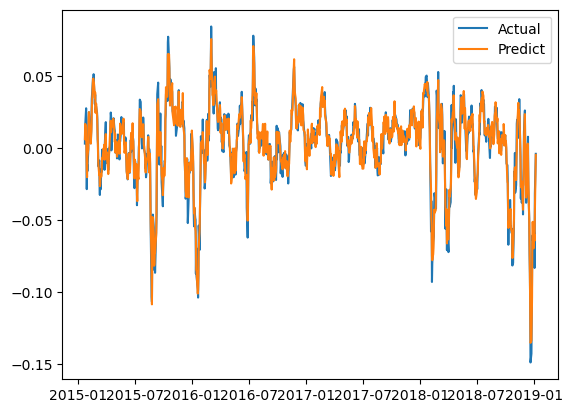

MSE: 4.6553486517984536e-05, R^2: 0.9379499280894464


In [144]:
test_mse_r2(lr_model4, X_train4, y_train4)

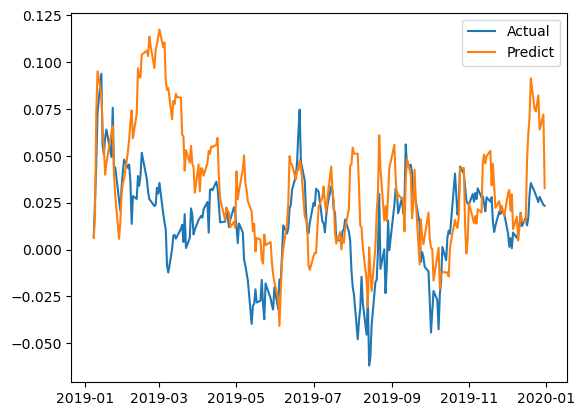

MSE: 0.001231828445672286, R^2: -0.9607425687637869


In [145]:
test_mse_r2(lr_model4, X_test4, y_test4)

# Random Forest

In [155]:
model_rf4 = train_random_forest(X_train4, y_train4, n_estimators=100, max_depth=None)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: -0.10771849456992988


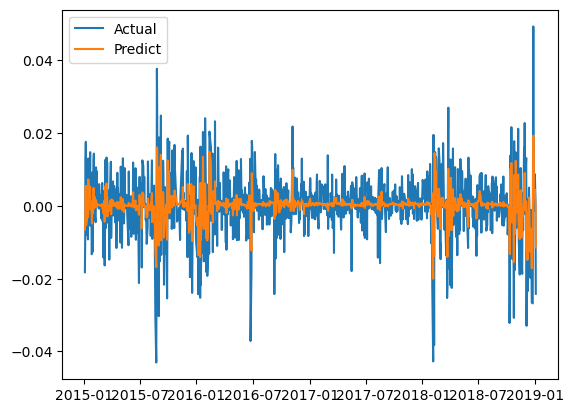

MSE: 3.646286966139263e-05, R^2: 0.5169580999797203


In [ ]:
best_model_rf3 = run_grid_search(model_rf3, param_grid, X_train3, y_train3, n_splits=3)

# Display the best parameters and score
print(f"Best Parameters: {best_model_rf3.best_params_}")
print(f"Best Score: {best_model_rf3.best_score_}")

test_mse_r2(best_model_rf3, X_train3, y_train3)

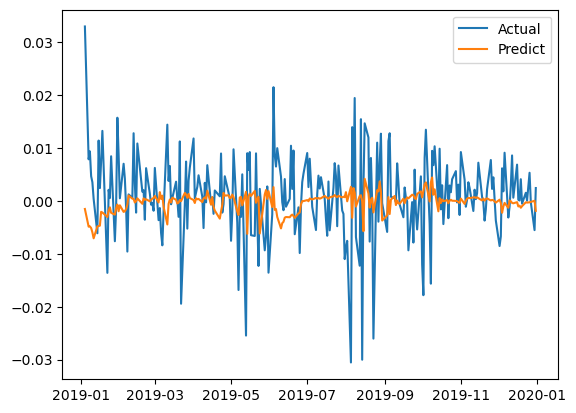

MSE: 6.780591446306916e-05, R^2: -0.12284599648883465


In [ ]:
test_mse_r2(best_model_rf3, X_test3, y_test3)

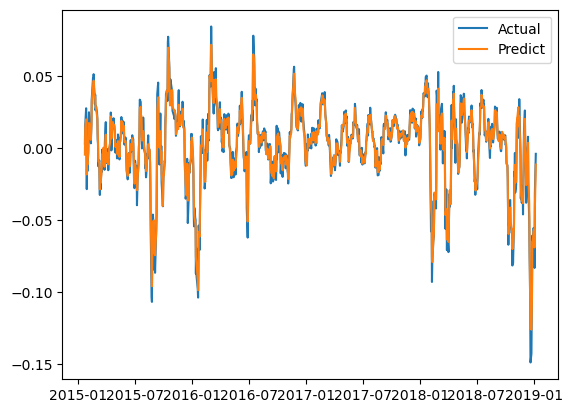

MSE: 1.903999065812505e-05, R^2: 0.974622034183057


In [156]:
model_rf4.fit(X_train4, y_train4)

test_mse_r2(model_rf4, X_train4, y_train4)

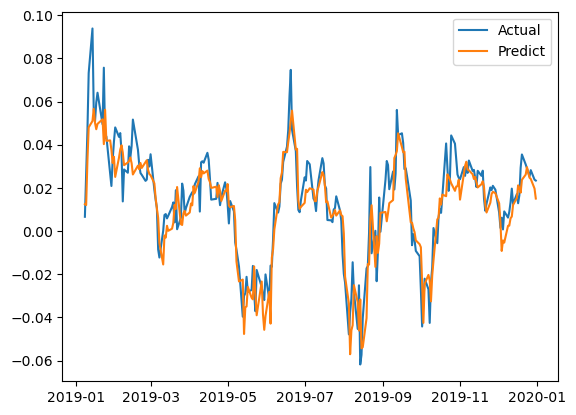

MSE: 0.000127755910774454, R^2: 0.796646640571814


In [160]:
model = model_rf4

predictions = model.predict(X_test4)
plt.plot(y_test4.index, y_test4, label="Actual")
plt.plot(y_test4.index, predictions, label="Predict")
plt.legend()
plt.show()
mse = mean_squared_error(y_test4, predictions)
r2 = r2_score(y_test4, predictions)
print(f"MSE: {mse}, R^2: {r2}")